In [1]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
odds = pd.read_csv("odds.csv")  # has season 2 odds
results = pd.read_csv("results.csv")  # has season 2 results
results1 = results.loc[results["SeasonID"]==1.0]
fixtures = pd.read_csv("fixtures.csv")  # only 2nd season
teams = pd.read_csv("teams.csv")  #team ID --> name key
starting = pd.read_csv("startingXI.csv")  
players = pd.read_csv("players.csv")  

First step is to produce a list of dataframes, one for each team, into which the data from the first season for each team can be placed. The Model to be used here is a poisson distribution based on the number of goals scored, which is reflected by the variables used as columns in these dataframes as seen below:

In [2]:
Gameweeks = list(range(1,55))
team_list = []
ind_variables = ["Points", "Position", "GamesPlayed", "GoalDifference", "GoalsFor", "GoalsAgainst"]
for team in list(teams["TeamID"].values):
    df = pd.DataFrame(index=Gameweeks, columns=["Points", "Position", "GamesPlayed", "GoalDifference", "GoalsFor", "GoalsAgainst", "HorA?"])
    df.fillna(0.0, inplace=True)
    team_list.append(df)
# index in team_list == TeamID -1

Below a league table dataframe called 'table' is made. After this, the league table and the dataframes for each individual team are filled with data from season one using the given results.

In [3]:
variables = ["Points", "GamesPlayed", "GoalDifference", "GoalsFor", "GoalsAgainst", "FormPrev3"]
table = pd.DataFrame(columns=variables, index=list(teams["TeamID"].values))  # index of table is each team's ID
table["FormPrev3"].values[:] = "___"
table.fillna(0.0, inplace=True)
table["Position"] = list(teams["TeamID"].values)

In [4]:
# Make table for first season and separate results for each team into the individual dataframes in the list 
# team_list- this list of dataframes can the be used later to analyse the statistics from the first season
# for each team individually.

Year1_results = results.loc[results["SeasonID"]==1]
league_won = 0
for i in range(1,55):
    week_results = Year1_results.loc[Year1_results["Gameweek"]==i]
    for index, row in week_results.iterrows():
        teamH = row.loc["HomeTeamID"]
        teamA = row.loc["AwayTeamID"]
        if row.loc["HomeScore"] == row.loc["AwayScore"]:
            table["Points"][teamH] = table.loc[teamH]["Points"] + 1
            table["GoalsFor"][teamH] = table.loc[teamH]["GoalsFor"] + row.loc["HomeScore"]
            table["GoalsAgainst"][teamH] = table.loc[teamH]["GoalsAgainst"] + row.loc["AwayScore"]
            table["FormPrev3"][teamH] = table.loc[teamH]["FormPrev3"][1:] + 'D'
                
            table["Points"][teamA] = table.loc[teamA]["Points"] + 1
            table["GoalsFor"][teamA] = table.loc[teamA]["GoalsFor"] + row.loc["AwayScore"]
            table["GoalsAgainst"][teamA] = table.loc[teamA]["GoalsAgainst"] +row.loc["HomeScore"]
            table["FormPrev3"][teamA] = table.loc[teamA]["FormPrev3"][1:] + 'D'
        
            table["GamesPlayed"][teamH] = i
            table["GamesPlayed"][teamA] = i
        
        if row.loc["HomeScore"] > row.loc["AwayScore"]:
            table["Points"][teamH] = table.loc[teamH]["Points"] + 3
            table["GoalDifference"][teamH] = table.loc[teamH]["GoalDifference"] + (row.loc["HomeScore"] - row.loc["AwayScore"] )
            table["GoalsFor"][teamH] = table.loc[teamH]["GoalsFor"] + row.loc["HomeScore"]
            table["GoalsAgainst"][teamH] = table.loc[teamH]["GoalsAgainst"] + row.loc["AwayScore"]
            table["FormPrev3"][teamH] = table.loc[teamH]["FormPrev3"][1:] + 'W'
          
            table["GoalDifference"][teamA] = table.loc[teamA]["GoalDifference"] +(row.loc["AwayScore"] - row.loc["HomeScore"] )
            table["GoalsFor"][teamA] = table.loc[teamA]["GoalsFor"] + row.loc["AwayScore"]
            table["GoalsAgainst"][teamA] = table.loc[teamA]["GoalsAgainst"] + row.loc["HomeScore"]
            table["FormPrev3"][teamA] = table.loc[teamA]["FormPrev3"][1:] + 'L'
         
            table["GamesPlayed"][teamH] = i
            table["GamesPlayed"][teamA] = i
        
        if row.loc["HomeScore"] < row.loc["AwayScore"]:
            table["GoalDifference"][teamH] = table.loc[teamH]["GoalDifference"] + (row.loc["HomeScore"] - row.loc["AwayScore"] )
            table["GoalsFor"][teamH] = table.loc[teamH]["GoalsFor"] + row.loc["HomeScore"]
            table["GoalsAgainst"][teamH] = table.loc[teamH]["GoalsAgainst"] + row.loc["AwayScore"]
            table["FormPrev3"][teamH] = table.loc[teamH]["FormPrev3"][1:] + 'L'
     
            table["Points"][teamA] = table.loc[teamA]["Points"] + 3
            table["GoalDifference"][teamA] = table.loc[teamA]["GoalDifference"] +(row.loc["AwayScore"] - row.loc["HomeScore"] )
            table["GoalsFor"][teamA] = table.loc[teamA]["GoalsFor"] + row.loc["AwayScore"]
            table["GoalsAgainst"][teamA] = table.loc[teamA]["GoalsAgainst"] + row.loc["HomeScore"]
            table["FormPrev3"][teamA] = table.loc[teamA]["FormPrev3"][1:] + 'W'
               
            table["GamesPlayed"][teamH] = i
            table["GamesPlayed"][teamA] = i
    table.sort_values("Points", ascending=False, inplace=True)
    table["Position"] = list(teams["TeamID"].values)
    difference_1_2 = table.loc[table["Position"][:2].index[0]]["Points"] - table.loc[table["Position"][:2].index[1]]["Points"]
    
    if league_won ==0:
        if difference_1_2 > 3 * (55-i):
            league_won = i #week number in which league was won
    
    for n, team in enumerate(team_list): 
        '''
        The value (n+1) is the team id --> use this to reference current week values
        from the table dataframe.
        Use the variable i to reference a particular gameweek in the team dataframe.
        '''
        for col in ind_variables:
            if col == "Position":
                team[col][i] = table.loc[n+1].index
            team[col][i] = table.loc[n+1][col]
table

,Points,GamesPlayed,GoalDifference,GoalsFor,GoalsAgainst,FormPrev3,Position
15,138.0,54.0,118.0,159.0,41.0,WWW,1
8,125.0,54.0,79.0,130.0,51.0,WWD,2
4,117.0,54.0,95.0,136.0,41.0,WLW,3
19,113.0,54.0,56.0,108.0,52.0,LWW,4
5,106.0,54.0,72.0,130.0,58.0,WWW,5
27,105.0,54.0,54.0,118.0,64.0,WDW,6
6,105.0,54.0,54.0,110.0,56.0,WWW,7
21,96.0,54.0,32.0,98.0,66.0,DWW,8
7,95.0,54.0,22.0,97.0,75.0,DLW,9
24,94.0,54.0,46.0,108.0,62.0,LLL,10


Now to prepare to make the predictive model by modifying the individual dataframes for each team are modified to include columns for betting odds and probabilities, and reformating some of the columns already present:

In [5]:
match_results = results.copy()
betting_odds = odds.copy()
for n, team in enumerate(team_list):
    '''
    The value (n+1) is the team id --> use this to reference current week values
    from the empty_table dataframe.
    Use the variable i to reference a particular gameweek in the team dataframe.
    '''

    # Add odds to each team's dataframe for each match:
    team["OddsFor"] = [0.0]*54
    team["OddsAgainst"] = [0.0]*54
    team["OddsDraw"] = [0.0]*54
    # Add probabilities columns for later:
    team["SkellamWin"] = [0.0]*54
    team["SkellamLose"] = [0.0]*54
    team["SkellamDraw"] = [0.0]*54
    resultsin = match_results.loc[match_results["SeasonID"] == 1]
    season_home_odds_current_team = resultsin.loc[resultsin["HomeTeamID"] == n + 1]
    season_away_odds_current_team = resultsin.loc[resultsin["AwayTeamID"] == n + 1]
    for index, row in team.iterrows():
        
        # if season_home_odds_current_team is not empty for the 'index'th week then the team was home
        # this week --> add these odds to the appropriate columns:
        if len(season_home_odds_current_team.loc[season_home_odds_current_team["Gameweek"] == index]["MatchID"]) == 1:
            # team is home
            matchid = season_home_odds_current_team.loc[season_home_odds_current_team["Gameweek"] == index]["MatchID"].values[0]
            matchhomeodds = betting_odds.loc[betting_odds["MatchID"] == matchid]["Home"].values[0]
            matchdrawodds = betting_odds.loc[betting_odds["MatchID"] == matchid]["Draw"].values[0]
            matchawayodds = betting_odds.loc[betting_odds["MatchID"] == matchid]["Away"].values[0]
            team["OddsFor"][index] = matchhomeodds
            team["OddsAgainst"][index] = matchawayodds
            team["OddsDraw"][index] = matchdrawodds
        
        # Alternatively, add away odds for the current week:
        elif len(season_away_odds_current_team.loc[season_away_odds_current_team["Gameweek"] == index]["MatchID"] == 1):
            # team is away
            matchid = season_away_odds_current_team.loc[season_away_odds_current_team["Gameweek"] == index]["MatchID"].values[0]
            matchhomeodds = betting_odds.loc[betting_odds["MatchID"] == matchid]["Home"].values[0]
            matchdrawodds = betting_odds.loc[betting_odds["MatchID"] == matchid]["Draw"].values[0]
            matchawayodds = betting_odds.loc[betting_odds["MatchID"] == matchid]["Away"].values[0]
            team["OddsFor"][index] = matchawayodds
            team["OddsAgainst"][index] = matchhomeodds
            team["OddsDraw"][index] = matchdrawodds
        
    # Reformat data so that it give values per week (i.e. goals scored per week) rather than cummulative
    # values:
    temp = team.iloc[::-1]
    GD_max = 0
    GF_max = 0
    for ind, row in temp.iterrows():
        if ind > 1:
            difference_points = team.loc[ind]["Points"] - team.loc[ind - 1]["Points"]
            difference_GD = team.loc[ind]["GoalDifference"] - team.loc[ind - 1]["GoalDifference"]
            difference_GF = team.loc[ind]["GoalsFor"] - team.loc[ind - 1]["GoalsFor"]
            difference_GA = team.loc[ind]["GoalsAgainst"] - team.loc[ind - 1]["GoalsAgainst"]
            if difference_GD > GD_max:
                GD_max = difference_GD
            if difference_GF > GF_max:
                GF_max = difference_GF
            team["GoalDifference"][ind] = difference_GD
            team["GoalsFor"][ind] = difference_GF
            team["GoalsAgainst"][ind] = difference_GA 

In [6]:
for n, t in enumerate(team_list):
    # n == python indexing, begins at n=0
    fixsH = results1.loc[results1["HomeTeamID"]==n+1][["Gameweek", "HomeTeamID"]]
    fixsA = results1.loc[results1["AwayTeamID"]==n+1][["Gameweek", "AwayTeamID"]]
    for ind, row in t.iterrows():
        # ind == Gameweek
        if ind in fixsH["Gameweek"].values:
            t["HorA?"][ind] = "H"
        elif ind in fixsA["Gameweek"].values:
            t["HorA?"][ind] = "A"
team_list[0]

,Points,Position,GamesPlayed,GoalDifference,GoalsFor,GoalsAgainst,HorA?,OddsFor,OddsAgainst,OddsDraw,SkellamWin,SkellamLose,SkellamDraw
1,1.0,14,1.0,0.0,1.0,1.0,A,3.89,1.92,3.96,0.0,0.0,0.0
2,4.0,5,2.0,2.0,2.0,0.0,A,1.51,6.43,4.72,0.0,0.0,0.0
3,7.0,5,3.0,2.0,3.0,1.0,A,1.50,6.19,4.99,0.0,0.0,0.0
4,8.0,6,4.0,0.0,1.0,1.0,H,1.96,3.71,4.00,0.0,0.0,0.0
5,11.0,6,5.0,4.0,5.0,1.0,H,1.86,4.09,4.02,0.0,0.0,0.0
6,12.0,7,6.0,0.0,1.0,1.0,H,5.52,1.62,4.29,0.0,0.0,0.0
7,15.0,6,7.0,1.0,2.0,1.0,H,1.58,5.45,4.66,0.0,0.0,0.0
8,18.0,6,8.0,1.0,1.0,0.0,A,1.79,4.45,4.08,0.0,0.0,0.0
9,19.0,6,9.0,0.0,0.0,0.0,A,5.99,1.54,4.65,0.0,0.0,0.0
10,19.0,7,10.0,-1.0,1.0,2.0,H,1.57,5.31,4.86,0.0,0.0,0.0


In [7]:
from scipy.stats import poisson,skellam
import matplotlib.pyplot as plt

The predictive model will use a skellam distribution. This assumes that the rate at which teams score goals is approximately independent of their opponents and constant, i.e. the rate of goal scoring can be modelled as a poisson proccess. To model a match using a skellam distribution, the average goals scored by the home and away team are required. Since there is often a difference in the average number of goals a team scored at home compared to away, the appropriate home or away average will be used inputted to the skellem distribution for each team in each match. 

Below the averages are calculated and placed in a list, and they are then used to compute the skellam probabilities for each match. This is done by looping through all the fixtures, and inputting the correct averages. The computed probabilities are then placed in the appropriate dataframes to be processed.

In [8]:
averages = []
for tm in team_list:
    averages.append([tm.loc[tm["HorA?"]=="H"]["GoalsFor"].mean(), tm.loc[tm["HorA?"]=="A"]["GoalsFor"].mean()])
averages
# index value in averages list is the TeamID - 1, as above

[[1.8148148148148149, 1.1481481481481481],
 [1.0, 0.5925925925925926],
 [1.037037037037037, 1.4814814814814814],
 [2.5925925925925926, 2.4444444444444446],
 [2.6666666666666665, 2.1481481481481484],
 [2.1481481481481484, 1.9259259259259258],
 [2.037037037037037, 1.5555555555555556],
 [2.8518518518518516, 1.962962962962963],
 [0.8148148148148148, 1.0740740740740742],
 [1.037037037037037, 0.5555555555555556],
 [1.962962962962963, 0.9629629629629629],
 [1.2962962962962963, 1.037037037037037],
 [1.7407407407407407, 1.1111111111111112],
 [1.3333333333333333, 1.0],
 [3.259259259259259, 2.6296296296296298],
 [1.1111111111111112, 0.8518518518518519],
 [2.4074074074074074, 0.8888888888888888],
 [1.2222222222222223, 1.1111111111111112],
 [2.037037037037037, 1.962962962962963],
 [0.7407407407407407, 1.0],
 [2.111111111111111, 1.5185185185185186],
 [1.8888888888888888, 0.9259259259259259],
 [1.8888888888888888, 1.2962962962962963],
 [2.259259259259259, 1.7407407407407407],
 [0.7777777777777778, 0.

In [9]:
fixtures

,SeasonID,Gameweek,MatchID,HomeTeamID,AwayTeamID
0,2,1,757,2,1
1,2,1,758,28,3
2,2,1,759,27,4
3,2,1,760,26,5
4,2,1,761,25,6
...,...,...,...,...,...
751,2,54,1508,10,19
752,2,54,1509,11,18
753,2,54,1510,12,17
754,2,54,1511,13,16


In [10]:
fixtures["Home"] = 0.0
fixtures["Away"] = 0.0
fixtures["Draw"] = 0.0
fixtures["Sum"] = 0.0
fixtures["Diff_HvA"] = 0.0
for i, fixt in fixtures.iterrows():
    Week = fixt["Gameweek"]
    HomeTeam = int(fixt["HomeTeamID"] - 1)
    AwayTeam = int(fixt["AwayTeamID"] - 1)
    skellam_pred = [skellam.pmf(i,  averages[HomeTeam][0], averages[AwayTeam][1]) for i in range(-6,8)]
    fixtures["Home"][i] = sum(skellam_pred[7:])
    fixtures["Away"][i] = sum(skellam_pred[:6])
    fixtures["Draw"][i] = skellam_pred[6]
    # include the "diff_HvA" column to compare the likelihood of a home or away win; if they are
    # close to being equally likely then a win or lose cannot be chosen
    fixtures["Diff_HvA"][i] = abs( sum(skellam_pred[7:]) - sum(skellam_pred[:6]) )
    fixtures["Sum"][i] = sum(skellam_pred[7:]) + sum(skellam_pred[:6]) + skellam_pred[6]
    
    # Add skellam probabilities to the team_list dataframes:
    team_list[HomeTeam]["SkellamWin"][Week] = sum(skellam_pred[7:])
    team_list[HomeTeam]["SkellamLose"][Week] = sum(skellam_pred[:6])
    team_list[HomeTeam]["SkellamDraw"][Week]  = skellam_pred[6]
    
    team_list[AwayTeam]["SkellamWin"][Week] = sum(skellam_pred[:6])
    team_list[AwayTeam]["SkellamLose"][Week] = sum(skellam_pred[7:])
    team_list[AwayTeam]["SkellamDraw"][Week] = skellam_pred[6]

In [11]:
variablesS2 = ["Points", "GamesPlayed"]
tableS2 = pd.DataFrame(columns=variablesS2, index=list(teams["TeamID"].values))  # index of table is each team's ID
tableS2.fillna(0.0, inplace=True)
tableS2["Position"] = list(teams["TeamID"].values)

In [12]:
fixtures.describe()

,SeasonID,Gameweek,MatchID,HomeTeamID,AwayTeamID,Home,Away,Draw,Sum,Diff_HvA
count,756.0,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000
mean,2.0,27.500000,1134.500000,14.500000,14.500000,0.456591,0.316955,0.224867,0.998413,0.311548
std,0.0,15.596102,218.382692,8.083095,8.083095,0.184278,0.166202,0.056425,0.002193,0.206106
min,2.0,1.000000,757.000000,1.000000,1.000000,0.081453,0.034322,0.084097,0.987137,0.000006
25%,2.0,14.000000,945.750000,7.750000,7.750000,0.315093,0.180329,0.188667,0.997973,0.125500
50%,2.0,27.500000,1134.500000,14.500000,14.500000,0.445016,0.296149,0.212735,0.999331,0.303415
75%,2.0,41.000000,1323.250000,21.250000,21.250000,0.610762,0.424288,0.264232,0.999781,0.470425
max,2.0,54.000000,1512.000000,28.000000,28.000000,0.868718,0.765733,0.398237,0.999998,0.834396


Now that every match has probabilties for a home win, away win or draw computed, the second season can be simulated. The question of when a draw should be assigned to a match is important, as the skellam model consistently predicts a lower probability for this case, compared to a win or draw. In practice, it was found that assigning a draw when the probabilities of a home and away win are sufficiently close and the probability of a draw was above some threshold work reasonably well. 

In [13]:
Count=[0,0,0]
# The Count variable is used to tune the model. In particular, it is used to adjust the ratio
# of draws : home wins : away wins. The proportion of draws in football is typically around
# 22% so the model is currently set up to produce this proportion. The values in the
# first condition are used to adjust this ratio, and with the current values the proportio
# of draws is 21%. Tuning the model to just one measure like this is of course somewhat 
# arbitray however, and other statistcial measures could be implemented to improve the model
# in its current form.
for innd, GAME in fixtures.iterrows():
    # Assign a draw if the probability of a draw is in the 75th percentile, or higher, and the 
    # difference between the probability of a win and loss is small, i.e. in the 
    # ~30th percentile or lower. 
    if GAME["Draw"] > 0.264232 and GAME["Diff_HvA"] < 0.22:
        Count[2] += 1
        tableS2["Points"][int(GAME["HomeTeamID"])] = tableS2.loc[int(GAME["HomeTeamID"])]["Points"] + 1
        tableS2["Points"][int(GAME["AwayTeamID"])] = tableS2.loc[int(GAME["AwayTeamID"])]["Points"] + 1
    elif GAME["Home"] > GAME["Away"]:
        Count[0] += 1
        tableS2["Points"][int(GAME["HomeTeamID"])] = tableS2.loc[int(GAME["HomeTeamID"])]["Points"] + 3
    elif GAME["Away"] > GAME["Home"]:
        Count[1] += 1
        tableS2["Points"][int(GAME["AwayTeamID"])] = tableS2.loc[int(GAME["AwayTeamID"])]["Points"] + 3
    
tableS2.sort_values("Points", ascending=False, inplace=True)
tableS2["Position"] = list(teams["TeamID"].values)
print(Count)
tableS2

[403, 196, 157]


,Points,GamesPlayed,Position
15,156.0,0.0,1
4,150.0,0.0,2
5,144.0,0.0,3
27,138.0,0.0,4
8,129.0,0.0,5
6,120.0,0.0,6
19,117.0,0.0,7
24,108.0,0.0,8
7,105.0,0.0,9
21,105.0,0.0,10


Is this a good prediction? Compare to the actual table to see:

In [14]:
variables = ["Points", "GamesPlayed", "GoalDifference", "GoalsFor", "GoalsAgainst", "FormPrev3"]
tableS2A = pd.DataFrame(columns=variables, index=list(teams["TeamID"].values))  # index of table is each team's ID
tableS2A["FormPrev3"].values[:] = "___"
tableS2A.fillna(0.0, inplace=True)
tableS2A["Position"] = list(teams["TeamID"].values)

In [15]:
# Make table for first season and separate results for each team into the individual dataframes in the list 
# team_list- this list of dataframes can the be used later to analyse the statistics from the first season
# for each team individually.

Year2_results = results.loc[results["SeasonID"]==2]
league_won = 0
for i in range(1,55):
    week_results = Year2_results.loc[Year2_results["Gameweek"]==i]
    for index, row in week_results.iterrows():
        teamH = row.loc["HomeTeamID"]
        teamA = row.loc["AwayTeamID"]
        if row.loc["HomeScore"] == row.loc["AwayScore"]:
            tableS2A["Points"][teamH] = tableS2A.loc[teamH]["Points"] + 1
            tableS2A["GoalsFor"][teamH] = tableS2A.loc[teamH]["GoalsFor"] + row.loc["HomeScore"]
            tableS2A["GoalsAgainst"][teamH] = tableS2A.loc[teamH]["GoalsAgainst"] + row.loc["AwayScore"]
            tableS2A["FormPrev3"][teamH] = tableS2A.loc[teamH]["FormPrev3"][1:] + 'D'
                
            tableS2A["Points"][teamA] = tableS2A.loc[teamA]["Points"] + 1
            tableS2A["GoalsFor"][teamA] = tableS2A.loc[teamA]["GoalsFor"] + row.loc["AwayScore"]
            tableS2A["GoalsAgainst"][teamA] = tableS2A.loc[teamA]["GoalsAgainst"] +row.loc["HomeScore"]
            tableS2A["FormPrev3"][teamA] = tableS2A.loc[teamA]["FormPrev3"][1:] + 'D'
        
            tableS2A["GamesPlayed"][teamH] = i
            tableS2A["GamesPlayed"][teamA] = i
        
        if row.loc["HomeScore"] > row.loc["AwayScore"]:
            tableS2A["Points"][teamH] = tableS2A.loc[teamH]["Points"] + 3
            tableS2A["GoalDifference"][teamH] = tableS2A.loc[teamH]["GoalDifference"] + (row.loc["HomeScore"] - row.loc["AwayScore"] )
            tableS2A["GoalsFor"][teamH] = tableS2A.loc[teamH]["GoalsFor"] + row.loc["HomeScore"]
            tableS2A["GoalsAgainst"][teamH] = tableS2A.loc[teamH]["GoalsAgainst"] + row.loc["AwayScore"]
            tableS2A["FormPrev3"][teamH] = tableS2A.loc[teamH]["FormPrev3"][1:] + 'W'
          
            tableS2A["GoalDifference"][teamA] = tableS2A.loc[teamA]["GoalDifference"] +(row.loc["AwayScore"] - row.loc["HomeScore"] )
            tableS2A["GoalsFor"][teamA] = tableS2A.loc[teamA]["GoalsFor"] + row.loc["AwayScore"]
            tableS2A["GoalsAgainst"][teamA] = tableS2A.loc[teamA]["GoalsAgainst"] + row.loc["HomeScore"]
            tableS2A["FormPrev3"][teamA] = tableS2A.loc[teamA]["FormPrev3"][1:] + 'L'
         
            tableS2A["GamesPlayed"][teamH] = i
            tableS2A["GamesPlayed"][teamA] = i
        
        if row.loc["HomeScore"] < row.loc["AwayScore"]:
            tableS2A["GoalDifference"][teamH] = tableS2A.loc[teamH]["GoalDifference"] + (row.loc["HomeScore"] - row.loc["AwayScore"] )
            tableS2A["GoalsFor"][teamH] = tableS2A.loc[teamH]["GoalsFor"] + row.loc["HomeScore"]
            tableS2A["GoalsAgainst"][teamH] = tableS2A.loc[teamH]["GoalsAgainst"] + row.loc["AwayScore"]
            tableS2A["FormPrev3"][teamH] = tableS2A.loc[teamH]["FormPrev3"][1:] + 'L'
     
            tableS2A["Points"][teamA] = tableS2A.loc[teamA]["Points"] + 3
            tableS2A["GoalDifference"][teamA] = tableS2A.loc[teamA]["GoalDifference"] +(row.loc["AwayScore"] - row.loc["HomeScore"] )
            tableS2A["GoalsFor"][teamA] = tableS2A.loc[teamA]["GoalsFor"] + row.loc["AwayScore"]
            tableS2A["GoalsAgainst"][teamA] = tableS2A.loc[teamA]["GoalsAgainst"] + row.loc["HomeScore"]
            tableS2A["FormPrev3"][teamA] = tableS2A.loc[teamA]["FormPrev3"][1:] + 'W'
               
            tableS2A["GamesPlayed"][teamH] = i
            tableS2A["GamesPlayed"][teamA] = i
    tableS2A.sort_values("Points", ascending=False, inplace=True)
    tableS2A["Position"] = list(teams["TeamID"].values)
tableS2A

,Points,GamesPlayed,GoalDifference,GoalsFor,GoalsAgainst,FormPrev3,Position
15,133.0,54.0,117.0,154.0,37.0,WWW,1
19,126.0,54.0,67.0,111.0,44.0,LWW,2
4,114.0,54.0,56.0,99.0,43.0,WWW,3
5,112.0,54.0,64.0,113.0,49.0,LLW,4
8,111.0,54.0,70.0,120.0,50.0,WWW,5
27,110.0,54.0,59.0,102.0,43.0,LWW,6
6,107.0,54.0,48.0,101.0,53.0,DWD,7
24,91.0,54.0,40.0,98.0,58.0,LLL,8
1,90.0,54.0,17.0,92.0,75.0,WDW,9
7,89.0,54.0,28.0,96.0,68.0,WLL,10


Although the predicted final position for most teams is different to their actual position, it seems like most teams are in the correct region of the table. This is of course as expected, given the large degree of randomness involved in sport. In particular, this simple model does not account for factors such as momentum which could be implemented in a similar way to above- e.g. instead of using last season's home and away goal averages use the last 10 match goals averages, or a instead of using goals scored use goals conceded. Initially, my plan was to implement a recurrent LSTM neural network model, and this seems entirely feasible given the data- multiple factors, such as the skellam probabilties and stats from the previous run of matches could be a part of such a model.

However, it is first necessary to evaluate the accuracy of the current model before using it as the premise for further work. In particular, what sort of margin of error is there associated with the predicted table?

Below I approximate the skellam model used above for individual matches to a trinomial distribution for each team over the season. By taking the average of the skellam probailities for W/L/D over the season for each team, this model can given an approximate range of values that a team might expect to score over the season:

In [16]:
from scipy.stats import multinomial

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

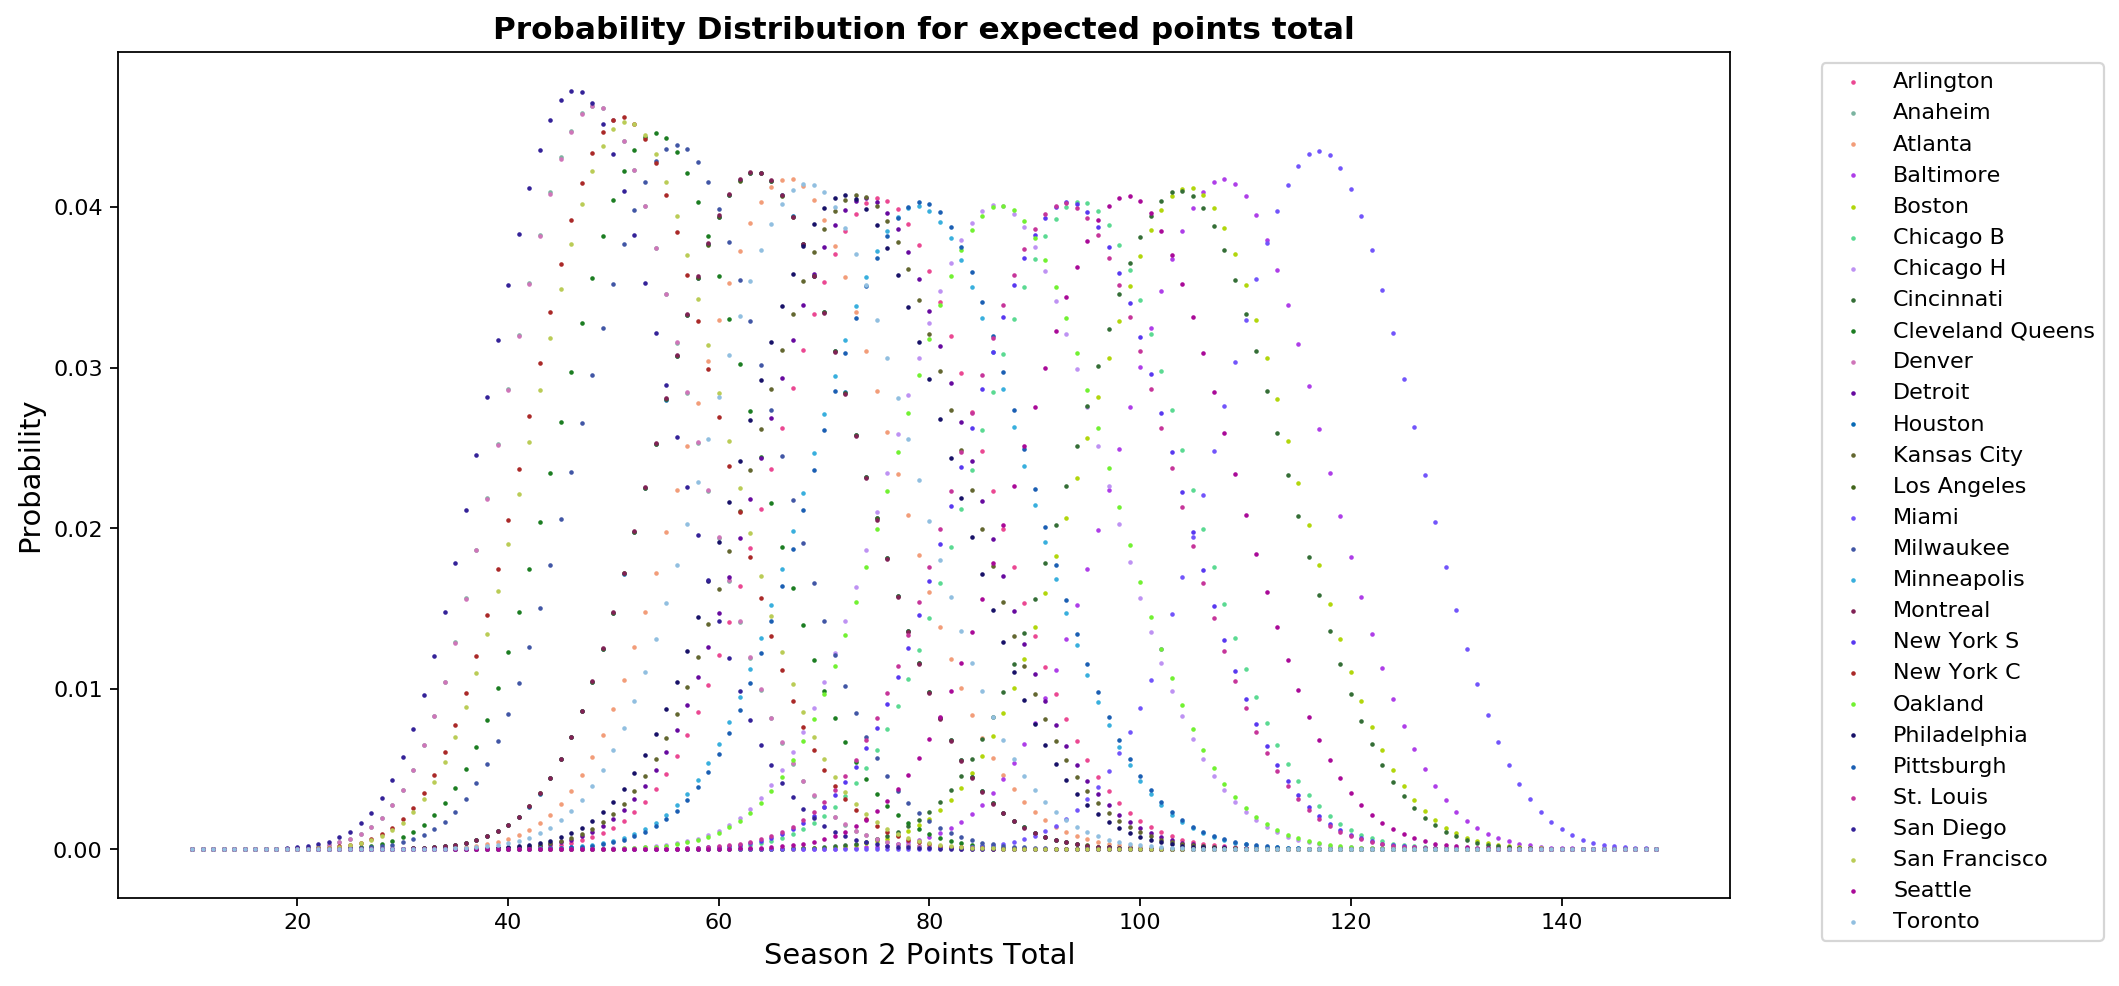

In [17]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
# figure(num=None, figsize=(16, 12), dpi=160, facecolor='w', edgecolor='k')
xx = range(10,150)
X = list(xx)
fig = plt.figure(num=None, figsize=(13, 7), dpi=160, facecolor='w', edgecolor='k')
ax1 = fig.add_subplot(111)
plt.xlabel("Season 2 Points Total ",size=13)
plt.ylabel("Probability",size=13)
plt.title("Probability Distribution for expected points total",size=14,fontweight='bold')
hands=[]
for i in range(28):
    WinAv =team_list[i]["SkellamWin"].mean()
    loseAv = team_list[i]["SkellamLose"].mean()
    drawAv = team_list[i]["SkellamDraw"].mean()
    rv = multinomial(54, [WinAv, drawAv, loseAv])
    DIST = []
    for j in range(0, 54):
        for k in range(0,54-j):
            DIST.append([rv.pmf([k, j, 54- k - j]), k*3 + j])
    values = [0.0]*162
    for num in DIST:
        values[int(num[1])] += num[0]
    ax1.scatter(X, values[9:149], s=1.1,c=np.random.rand(3,) , label=teams["TeamName"][i])

leg = ax1.legend(loc=2, bbox_to_anchor=(1.05, 1.0))
plt.show()

The above plot shows the probability distribution for total season points for each team. Given that the season is so long it is not surpising that the probabilities for each team are so low for a given exact position, and that there is a reasonably large range of points that a team might expect to achieve (a high standard deviation). However, there is still a large degree of granularity in this plot, and a clear distintion is visible even between adjacent distributions, which suggest the model is a good start.

An immediate starting point for improvement might be to approximate the above probability distributions to normal distributions, from which the standard error (or 'volatility') values could be obtained, which could then be useful in evaluating the model and making future predictions.